# Import Labriaries

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import JSON
from googleapiclient.discovery import build
import os
import pathlib
import re
import seaborn as sns

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Functions for YouTube data API

In [2]:
'''
Function to read through the info of the channels and create a dataframe
METHOD: .channels().list()
'''

def get_channel_stats(youtube, channel_ids):
    data = []
    
    # create request
    request = youtube.channels().list(part="snippet,contentDetails,statistics", id=channel_ids)
    
    response = request.execute()

    # loop through the channel
    for item in response['items']:
        info = {'ChannelName': item['snippet']['title'],
                'Subscribers': item['statistics']['subscriberCount'],
                'TotalViews': item['statistics']['viewCount'],
                'Videos': item['statistics']['videoCount'],
                'PlaylistID': item['contentDetails']['relatedPlaylists']['uploads'],   
               
               }
        data.append(info)
    return(pd.DataFrame(data))


'''
Function to create a list of the video IDs of a PlaylistID
METHOD: .playlistItems().list()
'''

def get_videoIDs(youtube, playlistID):
    video_IDs = []   
    
    request = youtube.playlistItems().list(part="snippet, contentDetails", playlistId=playlistID, maxResults=50) #maximum value by default
    response = request.execute()

     # loop through the items
    for item in response['items']:
        video_IDs.append(item['contentDetails']['videoId'])
                        
    next_page_token = response.get('nextPageToken')
    
    while next_page_token is not None:
        request = youtube.playlistItems().list(part="snippet, contentDetails", playlistId=playlistID, maxResults=50, pageToken=next_page_token) #maximum value by default
        response = request.execute()
    
     # loop through the items
        for item in response['items']:
            video_IDs.append(item['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')

        
    return video_IDs


'''
Function to read through the each video of the channel and create a dataframe
METHOD: .channels().list()
'''

def get_video_details(youtube, VideoList): 
    data = []
    j = 0
    
    # Loop through the video list in batches of 50
    while j < len(VideoList):
        # Create request
        request = youtube.videos().list(part="snippet,contentDetails,statistics", id=','.join(VideoList[j:j+50]))
        
        try:
            response = request.execute()
        except Exception as e:
            print(f"An error occurred: {e}")
            j += 50
            continue
    
        # Loop through the response items
        for item in response.get('items', []):
            info = {
                'VideoID': item['id'],
                'Date/Time': item['snippet']['publishedAt'],
                'Title': item['snippet']['title'],
                'Description': item['snippet']['description'],
                'Tags': item['snippet'].get('tags', []),   # Tags might not always be present
                'Duration': item['contentDetails']['duration'],
                'Definition': item['contentDetails']['definition'],
                'Caption': item['contentDetails']['caption'],
                'Views': item['statistics'].get('viewCount', None),  # Handle missing statistics
                'Likes': item['statistics'].get('likeCount', None),
                'Comments': item['statistics'].get('commentCount', None),
                #'Favorite': item['statistics'].get('favoriteCount', None)
            }
            data.append(info)
        
        j += 50  # Increment by 50 to get the next batch of video IDs
        print(f"Processed up to video index: {j}")
    
    # Convert the collected data into a DataFrame
    return pd.DataFrame(data)
    
    # Print the DataFrame to verify
    display(df)
    print(f"Total videos processed: {len(df)}")

# Retrieve Youtube data

## Read API key

In [3]:
file = open('API_key.txt')
api_key = file.read()
#api_key

## Import channel IDs

In [4]:
channel_ids = ['UC9HGzFGt7BLmWDqooUbWGBg', #Matthew ID
               'UCYqdbnuvx-jJZByotoNW-5Q', # Apollonia
              ]

## Build API client

In [5]:
api_service_name = "youtube"
api_version = "v3"

youtube = build(api_service_name, api_version, developerKey=api_key)

## Retrieve channel info/statistics | .channels() Method

In [6]:
df = get_channel_stats(youtube, channel_ids)
df

,ChannelName,Subscribers,TotalViews,Videos,PlaylistID
0,Apollonia Ponti,682000,105437501,1044,UUYqdbnuvx-jJZByotoNW-5Q
1,Matthew Hussey,3050000,541759009,942,UU9HGzFGt7BLmWDqooUbWGBg


## Retrieve video lists  |  .playlistItems() Method

In [7]:
# retrieve video list for Matthew
playlistID = df.loc[df['ChannelName'] == 'Matthew Hussey', 'PlaylistID'].iloc[0]
VideoList_mat = get_videoIDs(youtube, playlistID) 

# retrieve video list for Apollonia
playlistID = df.loc[df['ChannelName'] == 'Apollonia Ponti', 'PlaylistID'].iloc[0]
VideoList_apo = get_videoIDs(youtube,  playlistID) 
#VideoList_mat

## Retrieve video info and statistics  |  .videos() Method

### Build dataframe

In [8]:
video_mat = get_video_details(youtube, VideoList_mat)
video_apo = get_video_details(youtube, VideoList_apo)

Processed up to video index: 50
Processed up to video index: 100
Processed up to video index: 150
Processed up to video index: 200
Processed up to video index: 250
Processed up to video index: 300
Processed up to video index: 350
Processed up to video index: 400
Processed up to video index: 450
Processed up to video index: 500
Processed up to video index: 550
Processed up to video index: 600
Processed up to video index: 650
Processed up to video index: 700
Processed up to video index: 750
Processed up to video index: 800
Processed up to video index: 850
Processed up to video index: 900
Processed up to video index: 950
Processed up to video index: 50
Processed up to video index: 100
Processed up to video index: 150
Processed up to video index: 200
Processed up to video index: 250
Processed up to video index: 300
Processed up to video index: 350
Processed up to video index: 400
Processed up to video index: 450
Processed up to video index: 500
Processed up to video index: 550
Processed up

In [9]:
print()
print()
print('Dataframe Matthew')
print('---------------------------------------------------------------------------------------------------')
display(video_mat)
print()
print()
print('Dataframe Apollonia')
print('---------------------------------------------------------------------------------------------------')
display(video_apo)



Dataframe Matthew
---------------------------------------------------------------------------------------------------


,VideoID,Date/Time,Title,Description,Tags,Duration,Definition,Caption,Views,Likes,Comments
0,L5l_X4TXrZ8,2024-05-19T11:45:01Z,"How To AVOID Dating ""Players""","►► Get Vulnerable Stories, Real Insights, and ...","[Matthew Hussey, Matt Hussey, Get The Guy, How...",PT19M53S,hd,false,23556,873,57
1,JgKATVJUY7A,2024-05-15T17:34:12Z,Stop These Insecure Dating Behaviors! - w/ Sab...,"►► Get Vulnerable Stories, Real Insights, and ...","[Matthew Hussey, Matt Hussey, Get The Guy, How...",PT54M46S,hd,false,19169,692,35
2,ZQ13ZgSJwic,2024-05-15T15:00:36Z,"The Problem With Pretending We're ""Fine""",The toll pretending “we’re fine” takes on us c...,"[Matthew Hussey, Matt Hussey, Get The Guy, How...",PT1M,hd,false,21639,1592,21
3,nHqyyt66dQk,2024-05-12T12:05:06Z,THIS Is the Most Dangerous Moment in Dating......,"►► Get Vulnerable Stories, Real Insights and P...","[Matthew Hussey, Matt Hussey, Get The Guy, How...",PT12M50S,hd,false,63959,2566,187
4,l_Cjd2ya5R0,2024-05-11T15:00:42Z,Attracted to the Wrong People?,Why is it that we're drawn to people who treat...,"[Matthew Hussey, Matt Hussey, Get The Guy, How...",PT59S,hd,false,70636,5128,82
...,...,...,...,...,...,...,...,...,...,...,...
938,ndra_xByibg,2010-07-21T09:02:05Z,How To Flirt With A Guy - Surefire Tips For Wo...,►► Confused about what to text him? Just copy ...,"[flirting tips for women, flirting with men, f...",PT2M38S,hd,false,1880235,10226,1163
939,zkqYk2rJogs,2010-07-21T08:10:50Z,Powerful Conversational Flirting Tips For Wome...,►► Confused about what to text him? Just copy ...,"[flirting tips for women, flirting, flirting a...",PT2M13S,hd,false,923864,4294,316
940,osLuZa7SvDw,2010-07-16T11:51:38Z,The Best Places To Go On A Date - Avoid Gettin...,►► Confused about what to text him? Just copy ...,"[places to go on a date, dating advice, matthe...",PT1M50S,hd,false,171266,1216,117
941,RJe_C-iF3Bk,2010-07-15T17:43:41Z,How To Tell If A Guy Likes You Instantly - Pro...,►► Confused About Why Men Disappear? My FREE g...,"[how to tell if a guy likes you, how to know i...",PT1M32S,hd,false,2799481,13834,1609




Dataframe Apollonia
---------------------------------------------------------------------------------------------------


,VideoID,Date/Time,Title,Description,Tags,Duration,Definition,Caption,Views,Likes,Comments
0,5Y0nNvCkSrI,2024-05-20T13:00:08Z,The #1 Trap You Fall Into When Seeking Validat...,Subscribe Here: https://www.youtube.com/c/Apol...,"[shorts, shorts video, youtube shorts, dating,...",PT42S,hd,false,2113,92,3
1,UzmqwtC4TU8,2024-05-19T13:00:18Z,The Difference Between High Quality and Emotio...,Subscribe Here: https://www.youtube.com/c/Apol...,"[shorts, shorts video, youtube shorts, dating,...",PT39S,hd,false,2457,105,3
2,ojDaIZLIcz0,2024-05-18T13:00:46Z,Who Pays On The First Date? Watch This!,Subscribe Here: https://www.youtube.com/c/Apol...,"[shorts, shorts video, youtube shorts, dating,...",PT31S,hd,false,827,53,1
3,ybWnOmrEGN8,2024-05-15T16:00:55Z,Men With Broken Relationship With Their Mother...,"* 7-DAY FREE TRIAL ( APOLLONIA'S MEN""S MASTERY...","[dating advice for men, trauma, mother wound, ...",PT14M27S,hd,false,1910,162,58
4,ajIQ5KngR50,2024-05-15T13:00:05Z,The Truth On How To Make A Woman Miss You #shorts,Subscribe Here: https://www.youtube.com/c/Apol...,"[shorts, shorts video, youtube shorts, dating,...",PT1M,hd,false,3799,231,7
...,...,...,...,...,...,...,...,...,...,...,...
1040,mdza2ANvx4I,2017-12-19T15:15:32Z,Why Do I Dream So Much: Detect Signals Fast!,Why do I dream so much? I asked this question ...,"[why do i dream so much, dreams, what do dream...",PT4M39S,hd,false,52186,703,253
1041,ioKqqeURDyY,2017-12-14T22:02:26Z,How To Love: Why People Are Addicted to The Wr...,"HOW TO LOVE, is a big topic in this modern wor...","[How to love, addicted to love, how to love yo...",PT8M1S,hd,false,2742,118,6
1042,fnUmNM-ax2A,2017-12-13T01:04:05Z,How To Communicate in Relationships: 5 Tips To...,How to communicate in relationships is somethi...,"[how to communicate in relationships, communic...",PT7M42S,hd,false,9787,228,11
1043,gNEB21fANAc,2017-11-21T20:11:42Z,Signs She's Flirting With You! - Dating Advice...,FLIRTING CAN BE CONFUSING BUT NOT ANYMORE! In ...,"[flirting, how to flirt, flirting tips, relati...",PT2M59S,hd,false,9390,174,15


# Formatting and Structuring Dataframe
- nan values | unique values | type of values
- Format: Duration | Date & Time


## Functions for formatting and structuring

In [10]:
def convert_to_float(df, columns):
    '''
    Function to convert columns to float
    
        Args:
        - df (pd.DataFrame): Input DataFrame.
        - columns (list): List of columns to convert to float.
            
        Returns:
        - pd.DataFrame: Resulting DataFrame with converted columns.
        '''
    
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, setting errors to NaN
        df[col] = df[col].astype(float)  # Convert to float

'''
---------------------------------------------------------------------------
'''

def add_datetime_cols(df,col):
    '''
    Function to covert column to DateTime Format and add date and time columns
    
        Args:
        - df (pd.DataFrame): Input DataFrame.
        - column: String of the column to convert to DateTime Format.
            
        Returns:
        - pd.DataFrame: Resulting DataFrame with converted DateTime Format column with
                        new columns Date and Time.
        '''
    
    # Convert the 'datetime' column to a pandas datetime object
    df[col] = pd.to_datetime(df[col])
    
    # Create a new column for the date part
    df['Date'] = df[col].dt.date
    
    # Create a new column for the time part
    df['Time'] = df[col].dt.time

'''
---------------------------------------------------------------------------
'''

def duration_to_seconds(duration):
    """
    Convert a duration string in the format 'PT#M#S' to total seconds.

    Parameters:
    duration (str): Duration string in ISO 8601 format (e.g., 'PT15M4S' for 15 minutes and 4 seconds).

    Returns:
    int: Total duration in seconds. Returns None if the input format is incorrect.
    """
    # Pattern to match 'PT#H#M#S', 'PT#M#S', or 'PT#M'
    pattern = re.compile(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?')
    match = pattern.match(duration)
    if match:
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        seconds = int(match.group(3)) if match.group(3) else 0
        total_seconds = hours * 3600 + minutes * 60 + seconds
        return total_seconds
    else:
        return None



## Create Dataframe copy

In [11]:
mat_df = video_mat.copy()
apo_df = video_apo.copy()

# clean #shorts based on duration
apo_df = apo_df[~apo_df['Title'].str.lower().str.contains('#shorts')]

## Formatting and restructuring

In [12]:
# add columns Date and Time
col = 'Date/Time'
add_datetime_cols(mat_df,col)
add_datetime_cols(apo_df,col)

In [13]:
#convert Duration to total minutes
mat_df['TotalDuration(sec)'] = mat_df['Duration'].apply(duration_to_seconds)
apo_df['TotalDuration(sec)'] = apo_df['Duration'].apply(duration_to_seconds)

In [14]:
# convert numerical columns to float numbers
num_col = ['Views',	'Likes', 'Comments','TotalDuration(sec)']
convert_to_float(mat_df, num_col)
convert_to_float(apo_df, num_col)

In [15]:
# clean #shorts based on duration
mat_df = mat_df[mat_df['TotalDuration(sec)'] > 60].reset_index(drop=True)
apo_df = apo_df[apo_df['TotalDuration(sec)'] > 60].reset_index(drop=True)

In [16]:
# Comments and likes per 1000 view ratio
# the bigger the ratio the bigger the correlation
mat_df['LikeRatio'] = mat_df['Likes']/ mat_df['Views'] * 1000
mat_df['CommentRatio'] = mat_df['Comments']/ mat_df['Views'] * 1000

apo_df['LikeRatio'] = apo_df['Likes']/ apo_df['Views'] * 1000
apo_df['CommentRatio'] = apo_df['Comments']/ apo_df['Views'] * 1000

In [17]:
# create column Month of the Year
mat_df['Month_Year'] = mat_df['Date/Time'].dt.to_period('M')
apo_df['Month_Year'] = apo_df['Date/Time'].dt.to_period('M')

C:\Users\salto\AppData\Local\Temp\ipykernel_7588\2289946012.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  mat_df['Month_Year'] = mat_df['Date/Time'].dt.to_period('M')
C:\Users\salto\AppData\Local\Temp\ipykernel_7588\2289946012.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  apo_df['Month_Year'] = apo_df['Date/Time'].dt.to_period('M')


In [18]:
# clean dataframes
# there are NaN values in apo_df['Likes']
apo_df['Likes'].fillna(apo_df['Likes'].median(), inplace=True)

C:\Users\salto\AppData\Local\Temp\ipykernel_7588\2805001716.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  apo_df['Likes'].fillna(apo_df['Likes'].median(), inplace=True)


## Restructured Dataframe

In [19]:
print()
print()
print('Dataframe Matthew')
print('---------------------------------------------------------------------------------------------------')
display(mat_df)
print()
print()
print('Dataframe Apollonia')
print('---------------------------------------------------------------------------------------------------')
display(apo_df)



Dataframe Matthew
---------------------------------------------------------------------------------------------------


,VideoID,Date/Time,Title,Description,Tags,Duration,Definition,Caption,Views,Likes,Comments,Date,Time,TotalDuration(sec),LikeRatio,CommentRatio,Month_Year
0,L5l_X4TXrZ8,2024-05-19 11:45:01+00:00,"How To AVOID Dating ""Players""","►► Get Vulnerable Stories, Real Insights, and ...","[Matthew Hussey, Matt Hussey, Get The Guy, How...",PT19M53S,hd,false,23556.0,873.0,57.0,2024-05-19,11:45:01,1193.0,37.060621,2.419766,2024-05
1,JgKATVJUY7A,2024-05-15 17:34:12+00:00,Stop These Insecure Dating Behaviors! - w/ Sab...,"►► Get Vulnerable Stories, Real Insights, and ...","[Matthew Hussey, Matt Hussey, Get The Guy, How...",PT54M46S,hd,false,19169.0,692.0,35.0,2024-05-15,17:34:12,3286.0,36.099953,1.825865,2024-05
2,nHqyyt66dQk,2024-05-12 12:05:06+00:00,THIS Is the Most Dangerous Moment in Dating......,"►► Get Vulnerable Stories, Real Insights and P...","[Matthew Hussey, Matt Hussey, Get The Guy, How...",PT12M50S,hd,false,63959.0,2566.0,187.0,2024-05-12,12:05:06,770.0,40.119452,2.923748,2024-05
3,Xvk_v7uYgPw,2024-05-05 11:45:01+00:00,Afraid You'll Never Find Love? You NEED to Hea...,►► Transform Your Relationship with Life in 6 ...,"[Matthew Hussey, Matt Hussey, Get The Guy, How...",PT27M47S,hd,false,50367.0,2012.0,145.0,2024-05-05,11:45:01,1667.0,39.946791,2.878869,2024-05
4,10CsOVtc0EE,2024-05-03 16:03:14+00:00,Answering Your Questions LIVE,"Stopping by to say hi, answer a few questions ...",[],PT37M19S,hd,false,10684.0,183.0,41.0,2024-05-03,16:03:14,2239.0,17.128416,3.837514,2024-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,ndra_xByibg,2010-07-21 09:02:05+00:00,How To Flirt With A Guy - Surefire Tips For Wo...,►► Confused about what to text him? Just copy ...,"[flirting tips for women, flirting with men, f...",PT2M38S,hd,false,1880235.0,10226.0,1163.0,2010-07-21,09:02:05,158.0,5.438682,0.618540,2010-07
865,zkqYk2rJogs,2010-07-21 08:10:50+00:00,Powerful Conversational Flirting Tips For Wome...,►► Confused about what to text him? Just copy ...,"[flirting tips for women, flirting, flirting a...",PT2M13S,hd,false,923864.0,4294.0,316.0,2010-07-21,08:10:50,133.0,4.647870,0.342042,2010-07
866,osLuZa7SvDw,2010-07-16 11:51:38+00:00,The Best Places To Go On A Date - Avoid Gettin...,►► Confused about what to text him? Just copy ...,"[places to go on a date, dating advice, matthe...",PT1M50S,hd,false,171266.0,1216.0,117.0,2010-07-16,11:51:38,110.0,7.100067,0.683148,2010-07
867,RJe_C-iF3Bk,2010-07-15 17:43:41+00:00,How To Tell If A Guy Likes You Instantly - Pro...,►► Confused About Why Men Disappear? My FREE g...,"[how to tell if a guy likes you, how to know i...",PT1M32S,hd,false,2799481.0,13834.0,1609.0,2010-07-15,17:43:41,92.0,4.941630,0.574749,2010-07




Dataframe Apollonia
---------------------------------------------------------------------------------------------------


,VideoID,Date/Time,Title,Description,Tags,Duration,Definition,Caption,Views,Likes,Comments,Date,Time,TotalDuration(sec),LikeRatio,CommentRatio,Month_Year
0,ybWnOmrEGN8,2024-05-15 16:00:55+00:00,Men With Broken Relationship With Their Mother...,"* 7-DAY FREE TRIAL ( APOLLONIA'S MEN""S MASTERY...","[dating advice for men, trauma, mother wound, ...",PT14M27S,hd,false,1910.0,162.0,58.0,2024-05-15,16:00:55,867.0,84.816754,30.366492,2024-05
1,jYEel3Qt_kc,2024-05-10 15:53:18+00:00,Why Successful Men Struggle to Attract The Wom...,(BOOK A FREE DATING EVALUATION HERE) 3 MONTH A...,"[dating advice, dating, dating tips, how to ge...",PT15M49S,hd,false,3594.0,202.0,70.0,2024-05-10,15:53:18,949.0,56.204786,19.476906,2024-05
2,zFIiuPuBy-A,2024-05-01 05:58:16+00:00,"Are You The ""Standby"" Guy! (Don't be her backu...",Book a 45 Minute Consultation Call: https://ca...,"[don't be her backup choice, dating tips for m...",PT32M56S,hd,false,7145.0,259.0,40.0,2024-05-01,05:58:16,1976.0,36.249125,5.598321,2024-05
3,Hsazpez9FOY,2024-04-23 15:11:27+00:00,You Must Do This If You Want To EMOTIONALLY DE...,(BOOK A FREE DATING EVALUATION CALL) 3 MONTH A...,"[emotionally detach, dating advice for men, da...",PT9M53S,hd,false,13400.0,531.0,67.0,2024-04-23,15:11:27,593.0,39.626866,5.000000,2024-04
4,2ejmRUWy1ZY,2024-04-16 13:00:03+00:00,Stop Mistaking A Woman's Unavailability For Hi...,(BOOK A FREE DATING EVALUATION HERE) ATTRACTIO...,"[dating tips for men, dating advice for men, a...",PT13M35S,hd,false,6672.0,299.0,47.0,2024-04-16,13:00:03,815.0,44.814149,7.044365,2024-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,mdza2ANvx4I,2017-12-19 15:15:32+00:00,Why Do I Dream So Much: Detect Signals Fast!,Why do I dream so much? I asked this question ...,"[why do i dream so much, dreams, what do dream...",PT4M39S,hd,false,52186.0,703.0,253.0,2017-12-19,15:15:32,279.0,13.471046,4.848044,2017-12
747,ioKqqeURDyY,2017-12-14 22:02:26+00:00,How To Love: Why People Are Addicted to The Wr...,"HOW TO LOVE, is a big topic in this modern wor...","[How to love, addicted to love, how to love yo...",PT8M1S,hd,false,2742.0,118.0,6.0,2017-12-14,22:02:26,481.0,43.034282,2.188184,2017-12
748,fnUmNM-ax2A,2017-12-13 01:04:05+00:00,How To Communicate in Relationships: 5 Tips To...,How to communicate in relationships is somethi...,"[how to communicate in relationships, communic...",PT7M42S,hd,false,9787.0,228.0,11.0,2017-12-13,01:04:05,462.0,23.296209,1.123940,2017-12
749,gNEB21fANAc,2017-11-21 20:11:42+00:00,Signs She's Flirting With You! - Dating Advice...,FLIRTING CAN BE CONFUSING BUT NOT ANYMORE! In ...,"[flirting, how to flirt, flirting tips, relati...",PT2M59S,hd,false,9390.0,174.0,15.0,2017-11-21,20:11:42,179.0,18.530351,1.597444,2017-11


# Dataframe first-order Statistics

## Functions for first-order Statistics

In [20]:
def aggregate_numerical_columns(df, numerical_columns, aggregations):
    """
    Apply aggregation functions to numerical columns of a DataFrame.

    Args:
    - df (pd.DataFrame): Input DataFrame.
    - numerical_columns (list): List of numerical columns to aggregate.
    - aggregations (list): List of aggregation functions to apply to each numerical column.
                           Example: ['sum', 'mean']

    Returns:
    - pd.DataFrame: Resulting DataFrame with aggregated values.
    """
    # Create a dictionary with the same aggregations for all numerical columns
    agg_dict = {col: aggregations for col in numerical_columns}

    # Apply the aggregation functions using agg
    result = df[numerical_columns].agg(agg_dict)
    return result



In [21]:
num_col = ['Views',	'Likes', 'Comments', 'TotalDuration(sec)']
cat_col = ['Title',	'Description']

In [22]:
# Numerical columns
aggregations = ['sum', 'mean','median','quantile','min','max','count']

result_mat = aggregate_numerical_columns(mat_df, num_col, aggregations)
result_apo = aggregate_numerical_columns(apo_df, num_col, aggregations)

In [23]:
print()
print()
print('Statistics Matthew')
print('--------------------------------------------')
display(result_mat)
print()
print()
print('Statistics Apollonia')
print('--------------------------------------------')
display(result_apo)



Statistics Matthew
--------------------------------------------


,Views,Likes,Comments,TotalDuration(sec)
sum,5.191846e+08,9.701826e+06,658871.000000,582628.000000
mean,5.974507e+05,1.116436e+04,758.194476,670.457998
median,2.214050e+05,5.285000e+03,375.000000,455.000000
quantile,2.214050e+05,5.285000e+03,375.000000,455.000000
min,1.068400e+04,1.400000e+02,14.000000,69.000000
max,2.118953e+07,1.647350e+05,25333.000000,6809.000000
count,8.690000e+02,8.690000e+02,869.000000,869.000000




Statistics Apollonia
--------------------------------------------


,Views,Likes,Comments,TotalDuration(sec)
sum,1.032668e+08,2.331388e+06,184368.000000,609449.000000
mean,1.375057e+05,3.104378e+03,245.496671,811.516644
median,3.132300e+04,9.860000e+02,98.000000,565.000000
quantile,3.132300e+04,9.860000e+02,98.000000,565.000000
min,4.810000e+02,2.200000e+01,1.000000,76.000000
max,4.239491e+06,8.537500e+04,5039.000000,8064.000000
count,7.510000e+02,7.510000e+02,751.000000,751.000000


# Data Insights

## Functions for plotting

In [24]:
def plot_cumulative_data(data_tuples, **kwargs):
    """
    Plot the normalized cumulative values over time from specified columns of multiple dataframes.

    Parameters:
        data_tuples (list of tuples): List of tuples, where each tuple contains the date column and values column.
        **kwargs: Additional keyword arguments.

    Keyword Arguments:
        labels (list): List of labels for each dataset being plotted.

    Returns:
        None
    """
    # Create a figure
    plt.figure(figsize=(10, 6))

    labels = kwargs.get('labels', None)

    for i, (date_column, values_column) in enumerate(data_tuples):
        # Create a dataframe from the given columns
        df = pd.DataFrame({ 'Date': date_column, 'Values': values_column })

        # Sort the dataframe by date
        df_sorted = df.sort_values(by='Date')

        # Calculate cumulative values
        df_sorted['Cumulative_Values'] = df_sorted['Values'].cumsum()

        # Normalize cumulative values to the maximum value
        df_sorted['Cumulative_Values_Normalized'] = df_sorted['Cumulative_Values'] / df_sorted['Cumulative_Values'].max()

        # Plot the normalized cumulative values
        if labels and i < len(labels):
            label = labels[i]
        else:
            label = f'Dataset {i+1}'
        plt.plot(df_sorted['Date'], df_sorted['Cumulative_Values_Normalized'], label=label)

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Normalized Count')
  
    # Create the title based on values_column labels
    #values_column_label = ', '.join([f'Dataset {i+1}: {values_column.name}' for i, (date_column, values_column) in enumerate(data_tuples)])
    plt.title(f'Normalized Cumulative {values_column.name} Over Time')
    
    plt.legend()

    # Show the plot
    plt.show()


def plot_monthly_values(data_tuples, values_column='Views', **kwargs):
    """
    Plots monthly values for multiple datasets.

    Parameters:
        data_tuples (list of tuples): List of tuples, where each tuple contains the Month_Year column from a dataframe
                                      and the corresponding values column.
        values_column (str): The column name containing the values to plot.
        **kwargs: Additional keyword arguments.

    Keyword Arguments:
        labels (list): List of labels for each dataset being plotted.
    """
    labels = kwargs.get('labels', [f'Dataset {i+1}' for i in range(len(data_tuples))])
    
    # Create a figure and a subplot
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (month_year, values_col) in enumerate(data_tuples):
        # Calculate monthly sums of values
        monthly_values = values_col.groupby(month_year)[values_column].sum().reset_index()
        
        # Plot values
        ax.bar(monthly_values['Month_Year'].astype(str), monthly_values[values_column], label=f'{labels[i]} {values_column}', alpha=0.7)
    
    # Customize subplot
    ax.set_title(f'{values_column.capitalize()} Over Time (Monthly)')
    ax.set_ylabel('Count')
    ax.set_ylim([0, ax.get_ylim()[1]])  # Adjust y-axis to provide some padding above the max value
    ax.legend()
    
    # Reduce number of x-ticks and rotate them
    ax.set_xticks(ax.get_xticks()[::6])  # Show every 6th month
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


# Function to add a linear regression line to a plot
def add_linear_fit(ax, x, y):
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m * x + b, color='red')
    
    # Calculate correlation coefficient
    correlation_coefficient = np.corrcoef(x, y)[0, 1]
    
    # Add correlation coefficient to the plot
    ax.text(0.05, 0.95, f'Correlation Coefficient: {correlation_coefficient:.2f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top')





## Descriptive Statistics

### Numerical values | 'Views', 'Likes', 'TotalDuration'

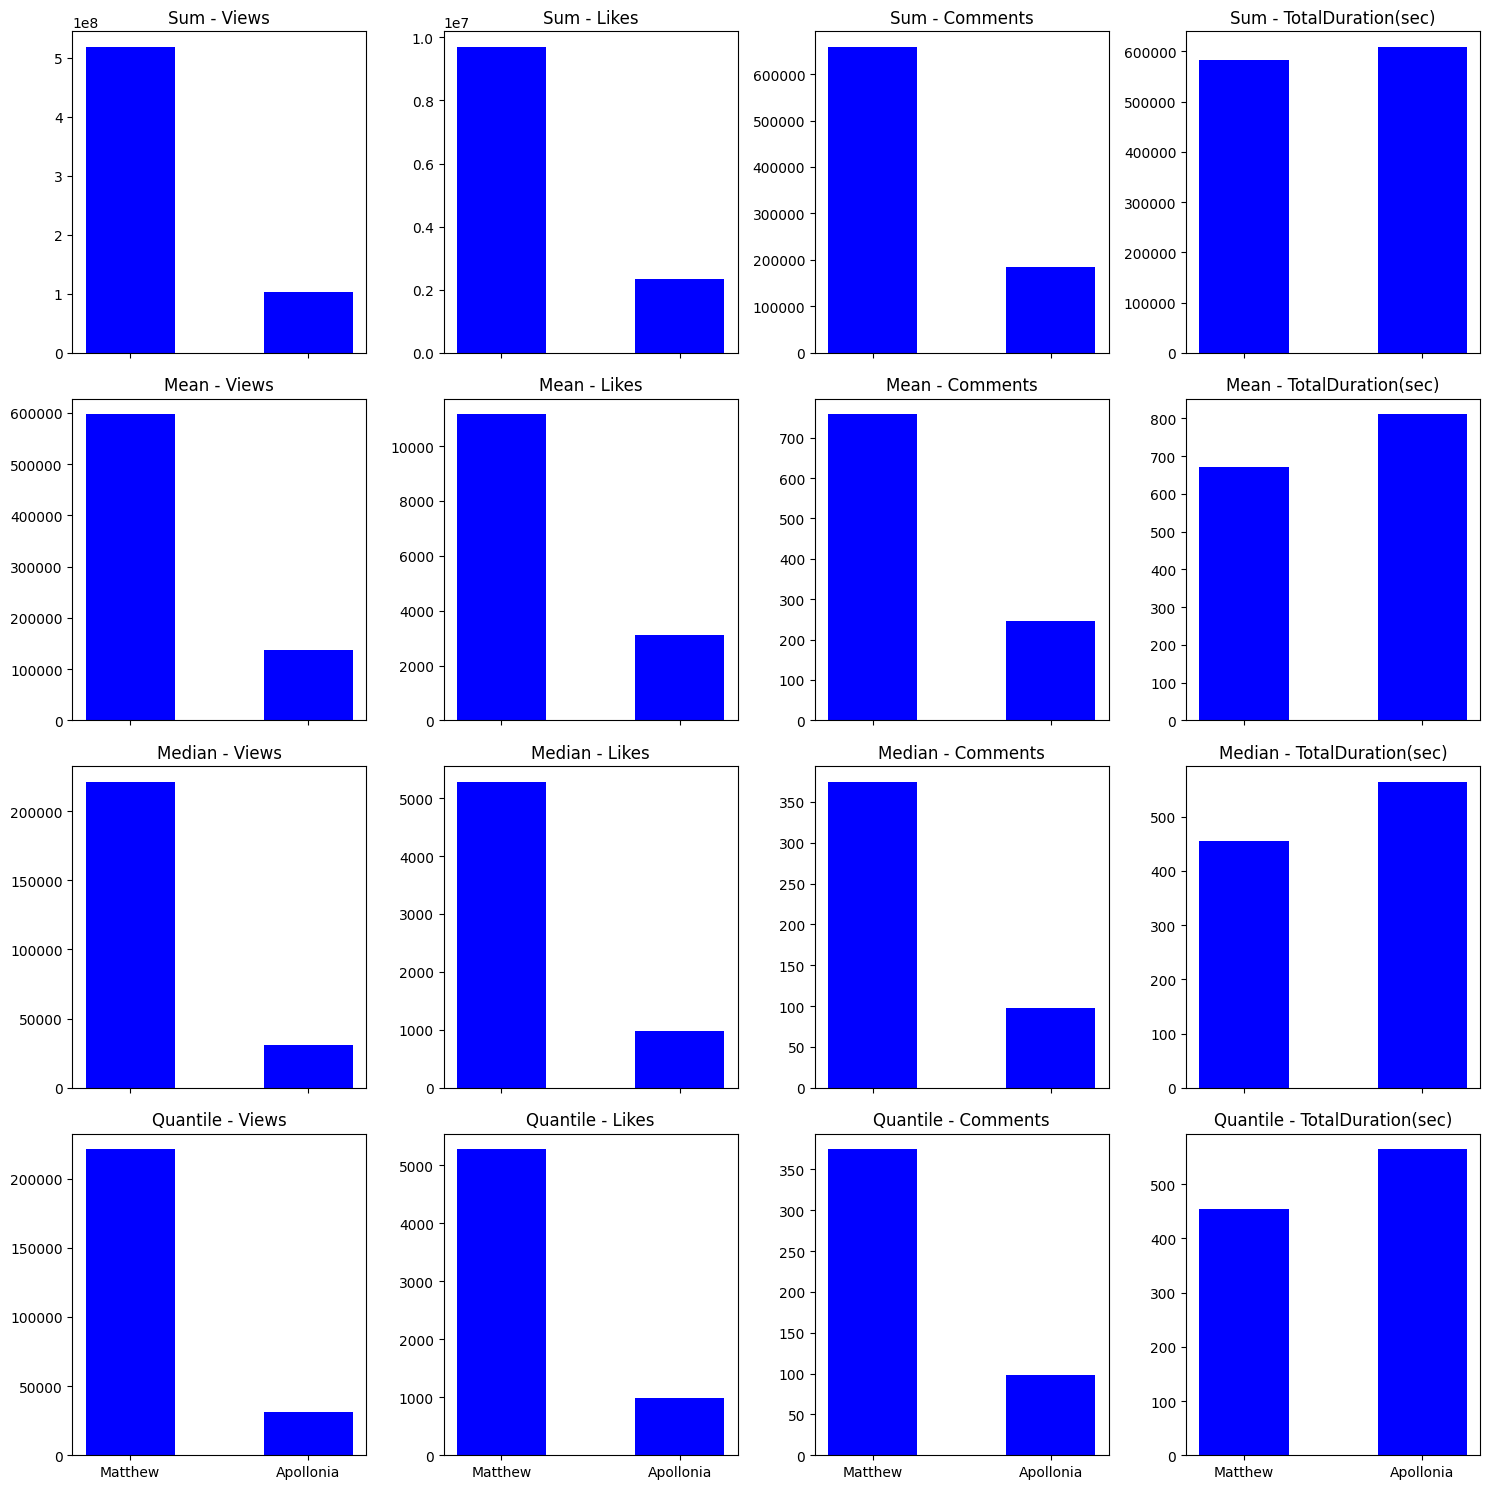

In [25]:
# aggreations to be plotted

aggregations = ['sum', 'mean', 'median', 'quantile']

# Plot the values for each DataFrame
fig, axes = plt.subplots(len(aggregations), len(num_col), figsize=(15, 15), sharex=True)

for i, agg_type in enumerate(aggregations):
    for j, col in enumerate(num_col):
        # Plot df1 values
        axes[i, j].bar(0, result_mat.loc[agg_type, col], width=0.1, color='blue', label='Matthew')
        
        # Plot df2 values
        axes[i, j].bar(0.2, result_apo.loc[agg_type, col], width=0.1, color='blue', label='Apollonia')
        
        axes[i, j].set_title(f'{agg_type.capitalize()} - {col}')
        axes[i, j].set_xticks([0, 0.2])
        axes[i, j].set_xticklabels(['Matthew', 'Apollonia'])


plt.tight_layout()
plt.show()


,VideoID,Date/Time,Title,Description,Tags,Duration,Definition,Caption,Views,Likes,Comments,Date,Time,TotalDuration(sec),LikeRatio,CommentRatio,Month_Year,Engagement Rate
0,ybWnOmrEGN8,2024-05-15 16:00:55+00:00,Men With Broken Relationship With Their Mother...,"* 7-DAY FREE TRIAL ( APOLLONIA'S MEN""S MASTERY...","[dating advice for men, trauma, mother wound, ...",PT14M27S,hd,false,1910.0,162.0,58.0,2024-05-15,16:00:55,867.0,84.816754,30.366492,2024-05,11.518325
1,jYEel3Qt_kc,2024-05-10 15:53:18+00:00,Why Successful Men Struggle to Attract The Wom...,(BOOK A FREE DATING EVALUATION HERE) 3 MONTH A...,"[dating advice, dating, dating tips, how to ge...",PT15M49S,hd,false,3594.0,202.0,70.0,2024-05-10,15:53:18,949.0,56.204786,19.476906,2024-05,7.568169
2,zFIiuPuBy-A,2024-05-01 05:58:16+00:00,"Are You The ""Standby"" Guy! (Don't be her backu...",Book a 45 Minute Consultation Call: https://ca...,"[don't be her backup choice, dating tips for m...",PT32M56S,hd,false,7145.0,259.0,40.0,2024-05-01,05:58:16,1976.0,36.249125,5.598321,2024-05,4.184745
3,Hsazpez9FOY,2024-04-23 15:11:27+00:00,You Must Do This If You Want To EMOTIONALLY DE...,(BOOK A FREE DATING EVALUATION CALL) 3 MONTH A...,"[emotionally detach, dating advice for men, da...",PT9M53S,hd,false,13400.0,531.0,67.0,2024-04-23,15:11:27,593.0,39.626866,5.000000,2024-04,4.462687
4,2ejmRUWy1ZY,2024-04-16 13:00:03+00:00,Stop Mistaking A Woman's Unavailability For Hi...,(BOOK A FREE DATING EVALUATION HERE) ATTRACTIO...,"[dating tips for men, dating advice for men, a...",PT13M35S,hd,false,6672.0,299.0,47.0,2024-04-16,13:00:03,815.0,44.814149,7.044365,2024-04,5.185851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,mdza2ANvx4I,2017-12-19 15:15:32+00:00,Why Do I Dream So Much: Detect Signals Fast!,Why do I dream so much? I asked this question ...,"[why do i dream so much, dreams, what do dream...",PT4M39S,hd,false,52186.0,703.0,253.0,2017-12-19,15:15:32,279.0,13.471046,4.848044,2017-12,1.831909
747,ioKqqeURDyY,2017-12-14 22:02:26+00:00,How To Love: Why People Are Addicted to The Wr...,"HOW TO LOVE, is a big topic in this modern wor...","[How to love, addicted to love, how to love yo...",PT8M1S,hd,false,2742.0,118.0,6.0,2017-12-14,22:02:26,481.0,43.034282,2.188184,2017-12,4.522247
748,fnUmNM-ax2A,2017-12-13 01:04:05+00:00,How To Communicate in Relationships: 5 Tips To...,How to communicate in relationships is somethi...,"[how to communicate in relationships, communic...",PT7M42S,hd,false,9787.0,228.0,11.0,2017-12-13,01:04:05,462.0,23.296209,1.123940,2017-12,2.442015
749,gNEB21fANAc,2017-11-21 20:11:42+00:00,Signs She's Flirting With You! - Dating Advice...,FLIRTING CAN BE CONFUSING BUT NOT ANYMORE! In ...,"[flirting, how to flirt, flirting tips, relati...",PT2M59S,hd,false,9390.0,174.0,15.0,2017-11-21,20:11:42,179.0,18.530351,1.597444,2017-11,2.012780


## Temporal Analysis

### Plot Views and Likes over time

Channel Views over time
----------------------------------------------

Views over time
----------------------------------------------



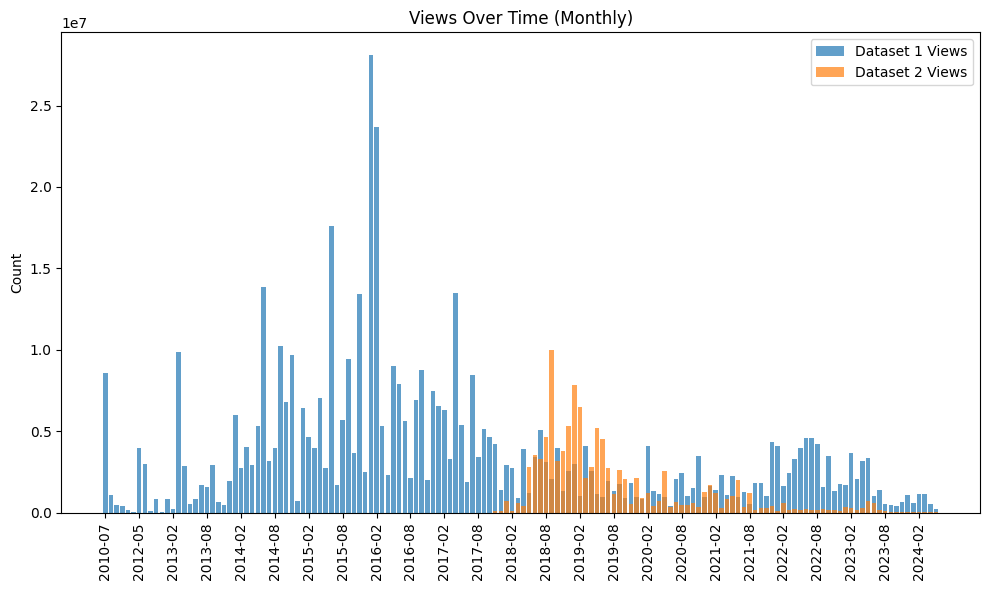

"\nprint()\nprint('----------------------------------------------')\nprint('Likes over time')\nprint('----------------------------------------------')\nprint()\ncol = 'Likes'\nplot_monthly_values(data_tuples, values_column=col, labels=['Matthew', 'Apollonia'])\n\n"

In [26]:
data_tuples = [(mat_df['Month_Year'], mat_df), (apo_df['Month_Year'], apo_df)]

print('Channel Views over time')
print('----------------------------------------------')
print()
print('Views over time')
print('----------------------------------------------')
print()
col = 'Views'
plot_monthly_values(data_tuples, values_column=col)

'''
print()
print('----------------------------------------------')
print('Likes over time')
print('----------------------------------------------')
print()
col = 'Likes'
plot_monthly_values(data_tuples, values_column=col, labels=['Matthew', 'Apollonia'])

'''


----------------------------------------------
Channel Growth over time
----------------------------------------------




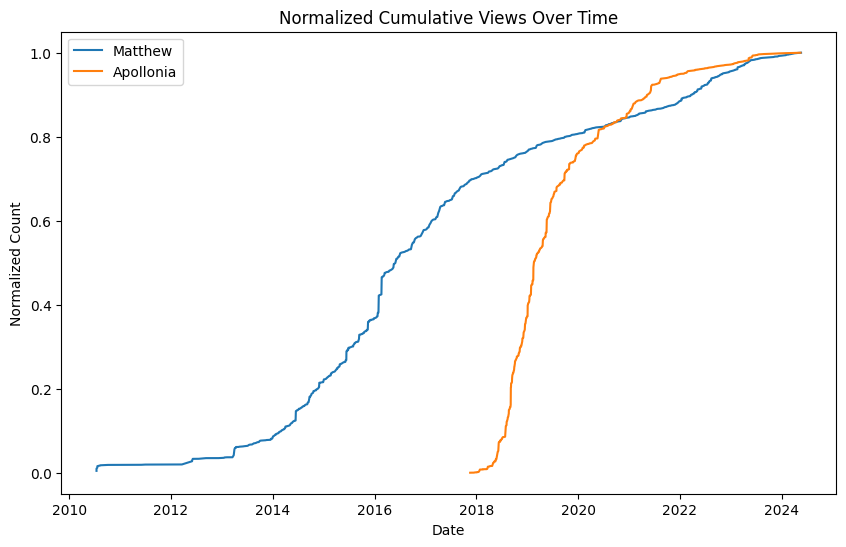

"\nprint()\nprint('----------------------------------------------')\nprint('in terms of Likes')\nprint('----------------------------------------------')\nprint()\ny_data = 'Likes'\nlabel1 = 'Matthew'\nlabel2 = 'Apollonia'\nplot_cumulative_data([(mat_df['Date'], mat_df[y_data]), (apo_df['Date'], apo_df[y_data])], labels=[label1, label2])\n\n"

In [27]:
print()
print('----------------------------------------------')
print('Channel Growth over time')
print('----------------------------------------------')
print()

print()
y_data = 'Views'
label1 = 'Matthew'
label2 = 'Apollonia'
plot_cumulative_data([(mat_df['Date'], mat_df[y_data]), (apo_df['Date'], apo_df[y_data])], labels=[label1, label2])

'''
print()
print('----------------------------------------------')
print('in terms of Likes')
print('----------------------------------------------')
print()
y_data = 'Likes'
label1 = 'Matthew'
label2 = 'Apollonia'
plot_cumulative_data([(mat_df['Date'], mat_df[y_data]), (apo_df['Date'], apo_df[y_data])], labels=[label1, label2])

'''

### Upload frequency

In [101]:
# Group by upload date and count the videos
mat_df_daily_uploads = mat_df.groupby('Date').size()
apo_df_daily_uploads = apo_df.groupby('Date').size()


# Calculate the days between uploads
mat_df_daily_uploads = mat_df_daily_uploads.reset_index(name='upload_count')
mat_df_daily_uploads['days_between_uploads'] = mat_df_daily_uploads['Date'].diff().dt.days

apo_df_daily_uploads = apo_df_daily_uploads.reset_index(name='upload_count')
apo_df_daily_uploads['days_between_uploads'] = apo_df_daily_uploads['Date'].diff().dt.days

# Fill NaN values resulting from the diff() calculation
mat_df_daily_uploads['days_between_uploads'] = mat_df_daily_uploads['days_between_uploads'].fillna(0).astype(int)
apo_df_daily_uploads['days_between_uploads'] = apo_df_daily_uploads['days_between_uploads'].fillna(0).astype(int)

# date for Matthew
specific_date = pd.to_datetime('2017-11-17')
# Filter the data to include only videos uploaded after the specific date
mat_df_daily_uploads = mat_df_daily_uploads[ pd.to_datetime(mat_df_daily_uploads['Date']) >= specific_date].reset_index()

# Calculate mean and standard deviation
matthew_mean = mat_df_daily_uploads['days_between_uploads'].mean()
matthew_std = mat_df_daily_uploads['days_between_uploads'].std()

apollonia_mean = apo_df_daily_uploads['days_between_uploads'].mean()
apollonia_std = apo_df_daily_uploads['days_between_uploads'].std()

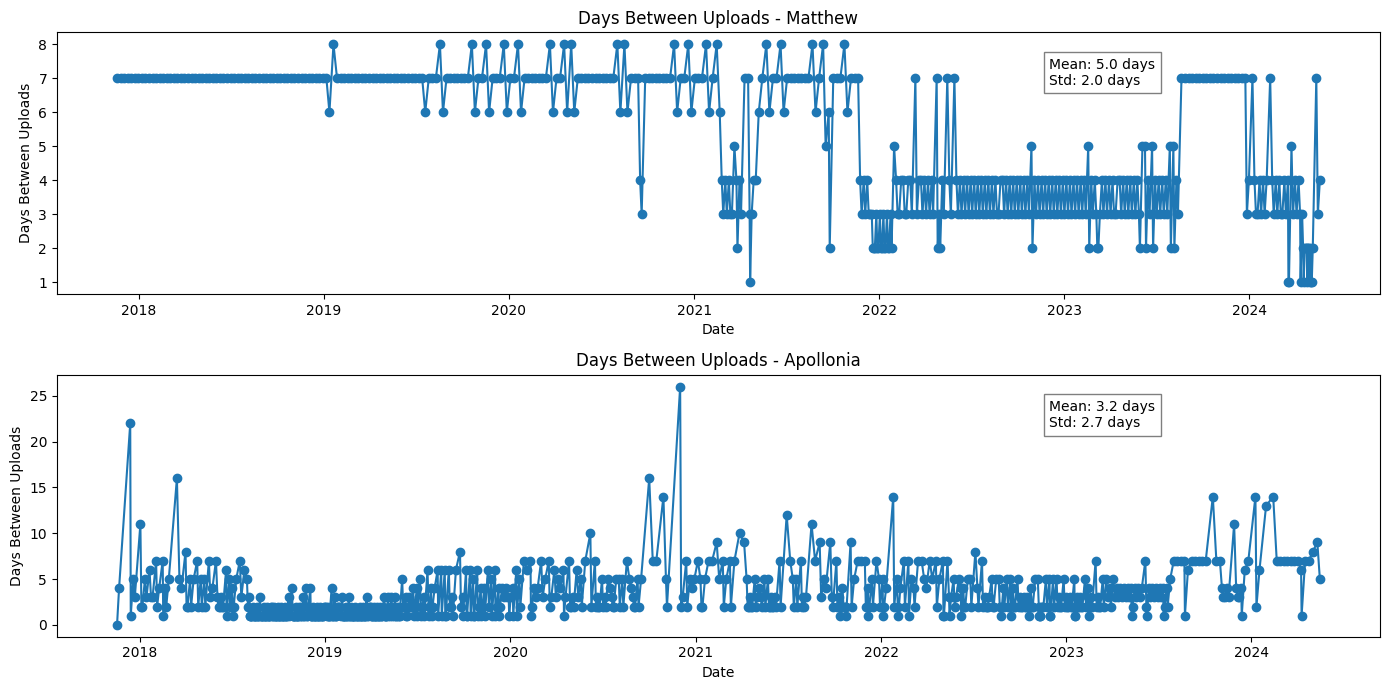

In [102]:
# Plotting days between uploads
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)

plt.plot(mat_df_daily_uploads['Date'] , mat_df_daily_uploads['days_between_uploads'], marker='o')
plt.title('Days Between Uploads - Matthew')
plt.ylabel('Days Between Uploads')
plt.xlabel('Date')
plt.annotate(f'Mean: {matthew_mean:.1f} days\nStd: {matthew_std:.1f} days', 
             xy=(0.75, 0.8), xycoords='axes fraction', fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.5))


plt.subplot(2, 1, 2)
plt.plot(apo_df_daily_uploads['Date'], apo_df_daily_uploads['days_between_uploads'], marker='o')
plt.title('Days Between Uploads - Apollonia')
plt.ylabel('Days Between Uploads')
plt.xlabel('Date')
plt.annotate(f'Mean: {apollonia_mean:.1f} days\nStd: {apollonia_std:.1f} days', 
             xy=(0.75, 0.8), xycoords='axes fraction', fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.5))


plt.tight_layout()
plt.show()


## Engagement Analysis

### Engagement Rate
Engagement Rate= (Likes+Comments)×100/ Views

Apollonia has a larger engagement rate (3.5 +/- 1.4) % compared to Matthew (2.6 +/- 1.0) % over the whole period, since 2010.
When we account for the same period of time (since 17/11/2017) Apollonia still has the highest engagement rate, but Matthews engagement has incresead to (3.2 +/- 0.9) % with smaller variance than Apollonia's rate.
There results indicate that Apollonias's videos are, on average, slightly more engaging for their viewerers compared to Matthew's content. But Matthew's viewer's are more consistent.


In [103]:
mat_df['Engagement Rate'] = 100*(mat_df['Likes']+mat_df['Comments'])/mat_df['Views']
apo_df['Engagement Rate'] = 100*(apo_df['Likes']+apo_df['Comments'])/apo_df['Views']
display(mat_df['Engagement Rate'].describe())
print()
display(apo_df['Engagement Rate'].describe())

count    869.000000
mean       2.630063
std        1.048211
min        0.226836
25%        1.837974
50%        2.593696
75%        3.321212
max        7.196756
Name: Engagement Rate, dtype: float64

count    751.000000
mean       3.546959
std        1.357647
min        0.415114
25%        2.616490
50%        3.353043
75%        4.322325
max       17.988730
Name: Engagement Rate, dtype: float64

In [105]:
# date for Matthew
specific_date = pd.to_datetime('2017-11-17')
# Filter the data to include only videos uploaded after the specific date
mat_df_filter = mat_df[ pd.to_datetime(mat_df['Date']) >= specific_date].reset_index()
display(mat_df_filter['Engagement Rate'].describe())

count    474.000000
mean       3.209295
std        0.904946
min        0.749588
25%        2.601198
50%        3.111592
75%        3.718907
max        7.196756
Name: Engagement Rate, dtype: float64

### Views Distribution

Matthew's channel have quite large variance in the views, suggesting that there are a few viral videos. While Apollonia's channel, despite the fact that the total views are less the views distribtuion is more consistent across videos.


In [80]:
'''
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot histograms with KDE
sns.histplot(mat_df['Views'], kde=True, ax=axes[0])
sns.histplot(apo_df['Views'], kde=True, ax=axes[1])

# Add titles
axes[0].set_title('Matthew - Views Distribution')
axes[1].set_title('Apollonia - Views Distribution')

# Set the same y-axis range for both subplots
axes[0].set_ylim(0, 450)
axes[1].set_ylim(0, 450)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
'''

"\n# Create subplots\nfig, axes = plt.subplots(1, 2, figsize=(10, 5))\n\n# Plot histograms with KDE\nsns.histplot(mat_df['Views'], kde=True, ax=axes[0])\nsns.histplot(apo_df['Views'], kde=True, ax=axes[1])\n\n# Add titles\naxes[0].set_title('Matthew - Views Distribution')\naxes[1].set_title('Apollonia - Views Distribution')\n\n# Set the same y-axis range for both subplots\naxes[0].set_ylim(0, 450)\naxes[1].set_ylim(0, 450)\n\n# Adjust layout\nplt.tight_layout()\n\n# Show the plot\nplt.show()\n"

Kernel density: a continuous curve (the kernel) is drawn at every individual data point and all of these curves are then added together to make a single smooth density estimation. The kernel most often used is a Gaussian (which produces a Gaussian bell curve at each data point).

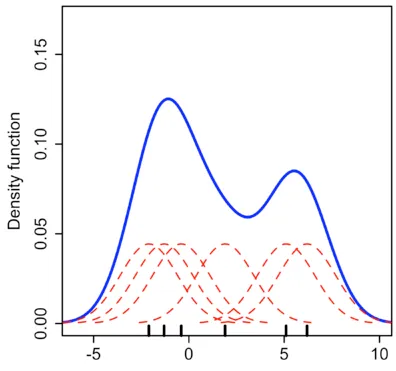

source: https://towardsdatascience.com/

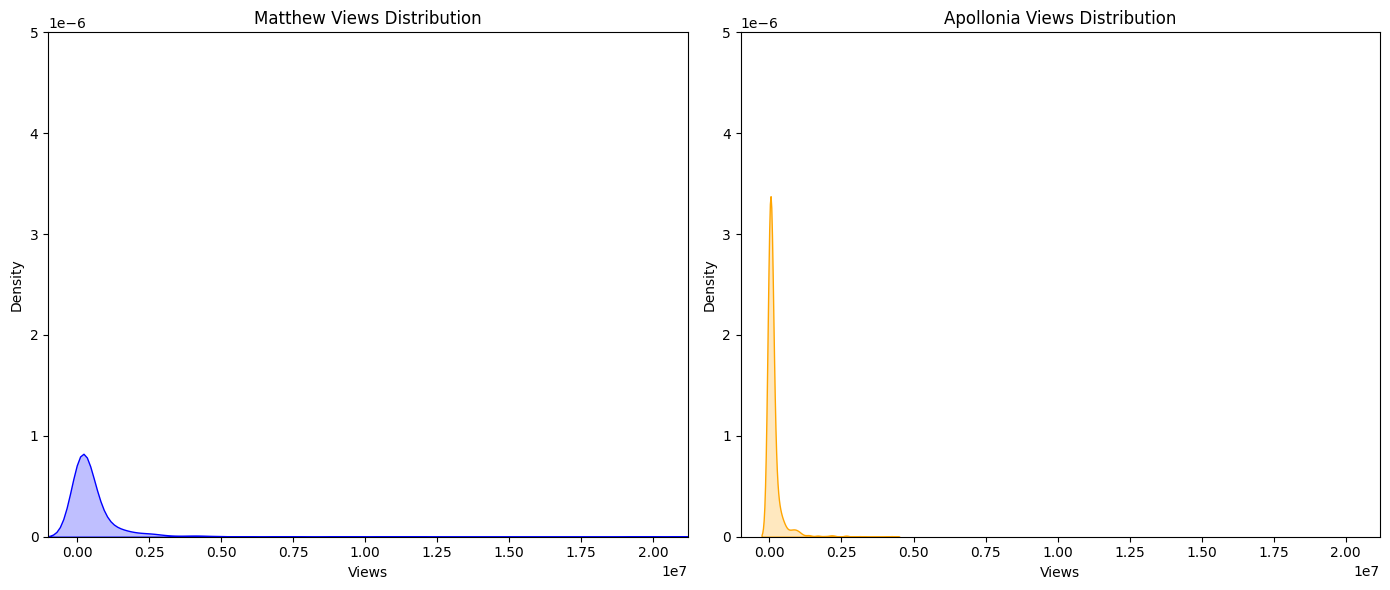

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Plot KDE lines together
sns.kdeplot(mat_df['Views'], color='blue', fill= True, label='Matthew', ax=axes[0])
sns.kdeplot(apo_df['Views'], color='orange', fill= True, label='Apollonia', ax=axes[1])

axes[0].set_title('Matthew Views Distribution')
axes[1].set_title('Apollonia Views Distribution')

# Set the same y-axis range for both subplots
axes[0].set_ylim(0, 5e-6)
axes[1].set_ylim(0, 5e-6)

max_views = max(mat_df['Views'].max(), apo_df['Views'].max())

# Set the same x-axis range for both subplots
axes[0].set_xlim(-1e6, max_views)
axes[1].set_xlim(-1e6, max_views)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Likes & Comments | Views

The number of likes seems to suggest stronger correlation than the number of comments. 
We, also, observe stronger correlation for Apollonia's channel. 
However, this is expected as the more people watching a video, the more likely this video will get comments and likes. 
To correct for this factor, we will plot these relationships again using the comments per 1000 view and likes per 1000 view ratios.

In both channels the like-view and comment-view correlations seem to disappear. Many videos have millions of views and relatevily few likes and comments. 
For Matthew's channel there is subtle correlation especially at like-view relationship. That indicates possibly that more peolpe would hit the like button at a video of Matthew with many likes.
Also we see that the CommentRatio at Apollonia's channel reaches higher values, meaning that Apollonia's videos get more comments and people put the effort to write a comment, despite the fewer views. It is worth checking the comments section to retrieve insights of the comment content of the audience!

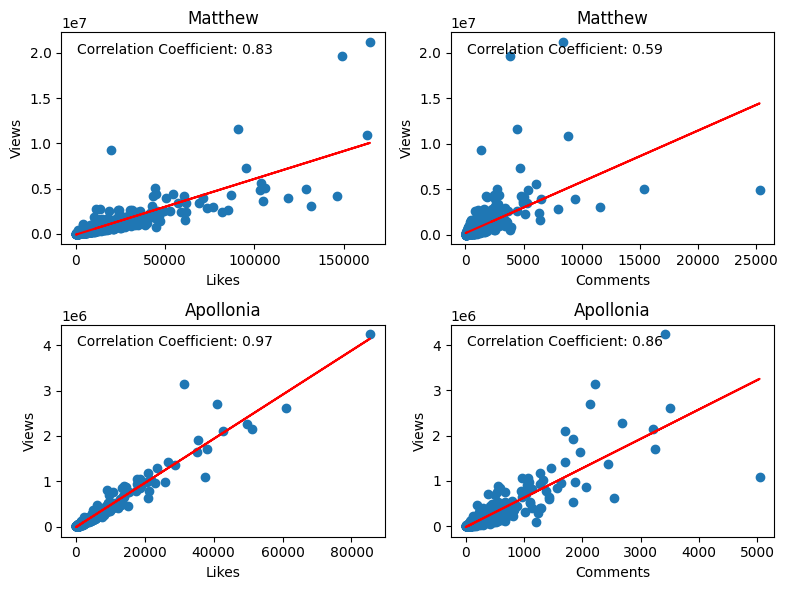

In [30]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Plot scatter and linear fit
axes[0, 0].scatter(mat_df['Likes'], mat_df['Views'])
add_linear_fit(axes[0, 0], mat_df['Likes'], mat_df['Views'])

axes[0, 1].scatter(mat_df['Comments'], mat_df['Views'])
add_linear_fit(axes[0, 1], mat_df['Comments'], mat_df['Views'])

axes[1, 0].scatter(apo_df['Likes'], apo_df['Views'])
add_linear_fit(axes[1, 0], apo_df['Likes'], apo_df['Views'])

axes[1, 1].scatter(apo_df['Comments'], apo_df['Views'])
add_linear_fit(axes[1, 1], apo_df['Comments'], apo_df['Views'])


# Add axis labels
axes[0, 0].set_xlabel('Likes')
axes[0, 0].set_ylabel('Views')
axes[0, 1].set_xlabel('Comments')
axes[0, 1].set_ylabel('Views')
axes[1, 0].set_xlabel('Likes')
axes[1, 0].set_ylabel('Views')
axes[1, 1].set_xlabel('Comments')
axes[1, 1].set_ylabel('Views')

axes[0, 0].set_title('Matthew')
axes[0, 1].set_title('Matthew')
axes[1, 0].set_title('Apollonia')
axes[1, 1].set_title('Apollonia')



# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

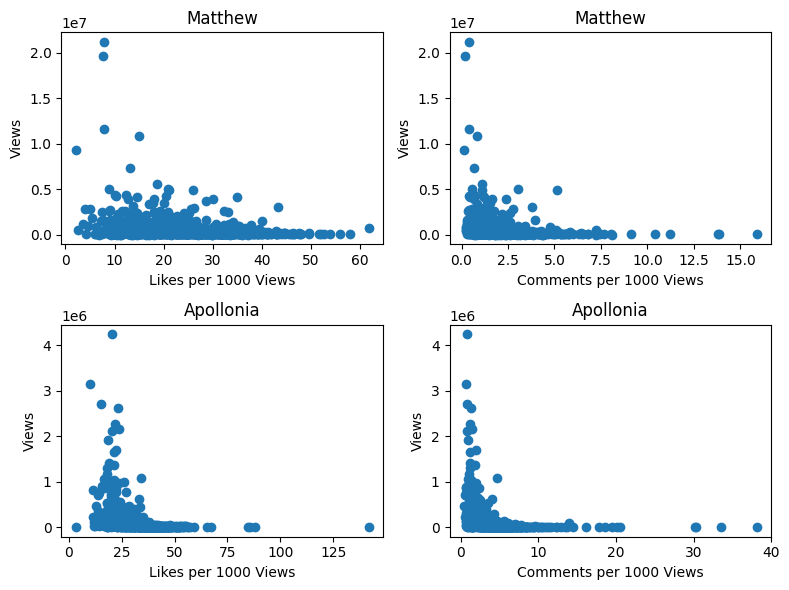

In [31]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Plot scatter and linear fit
axes[0, 0].scatter(mat_df['LikeRatio'], mat_df['Views'])

axes[0, 1].scatter(mat_df['CommentRatio'], mat_df['Views'])

axes[1, 0].scatter(apo_df['LikeRatio'], apo_df['Views'])

axes[1, 1].scatter(apo_df['CommentRatio'], apo_df['Views'])


# Add axis labels
axes[0, 0].set_xlabel('Likes per 1000 Views')
axes[0, 0].set_ylabel('Views')
axes[0, 1].set_xlabel('Comments per 1000 Views')
axes[0, 1].set_ylabel('Views')
axes[1, 0].set_xlabel('Likes per 1000 Views')
axes[1, 0].set_ylabel('Views')
axes[1, 1].set_xlabel('Comments per 1000 Views')
axes[1, 1].set_ylabel('Views')


axes[0, 0].set_title('Matthew')
axes[0, 1].set_title('Matthew')
axes[1, 0].set_title('Apollonia')
axes[1, 1].set_title('Apollonia')


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Views, Likes & Comments | Video Duration

Shorter videos tend to get more likes and comments than very long videos.
This is more evident in Apollonia's channel

In [32]:
'''
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Calculate mean and standard deviation
mean1 = np.mean(mat_df[mat_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)
median1 = np.median(mat_df[mat_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)
std1 = np.std(mat_df[mat_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)

mean2 = np.mean(apo_df[apo_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)
median2 = np.median(apo_df[apo_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)
std2 = np.std(apo_df[apo_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)

# Plot histograms with KDE
sns.histplot(mat_df[mat_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60, kde=False, ax=axes[0])
sns.histplot(apo_df[apo_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60, kde=False, ax=axes[1])

# Add the mean lines
axes[0].axvline(mean1, color='r', linestyle='--', label=f'Mean: {mean1:.2f}')
axes[1].axvline(mean2, color='r', linestyle='--', label=f'Mean: {mean2:.2f}')

# Add the median lines
axes[0].axvline(median1, color='orange', linestyle='--', label=f'Median: {median1:.2f}')
axes[1].axvline(median2, color='orange', linestyle='--', label=f'Median: {median2:.2f}')

# Add the std lines
axes[0].axvline(mean1 - std1, color='g', linestyle='--', label=f'Std Dev: {mean1 - std1:.2f}')
axes[0].axvline(mean1 + std1, color='g', linestyle='--')

axes[1].axvline(mean2 - std2, color='g', linestyle='--', label=f'Std Dev: {mean2 - std2:.2f}')
axes[1].axvline(mean2 + std2, color='g', linestyle='--')


# Add titles
axes[0].set_title('Matthew - Video Duration Distribution')
axes[1].set_title('Apollonia - Video Duration Distribution')

axes[0].set_xlabel('TotalDuration(min)')
axes[1].set_xlabel('TotalDuration(min)')

# Set the same y-axis range for both subplots
axes[0].set_ylim(0, 200)
axes[1].set_ylim(0, 200)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
'''

"\n# Create subplots\nfig, axes = plt.subplots(1, 2, figsize=(10, 5))\n\n# Calculate mean and standard deviation\nmean1 = np.mean(mat_df[mat_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)\nmedian1 = np.median(mat_df[mat_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)\nstd1 = np.std(mat_df[mat_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)\n\nmean2 = np.mean(apo_df[apo_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)\nmedian2 = np.median(apo_df[apo_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)\nstd2 = np.std(apo_df[apo_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60)\n\n# Plot histograms with KDE\nsns.histplot(mat_df[mat_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60, kde=False, ax=axes[0])\nsns.histplot(apo_df[apo_df['TotalDuration(sec)'] < 3600]['TotalDuration(sec)']/60, kde=False, ax=axes[1])\n\n# Add the mean lines\naxes[0].axvline(mean1, color='r', linestyle='--', label=f'Mean: {mean1:.2f}')\naxes[1].axv

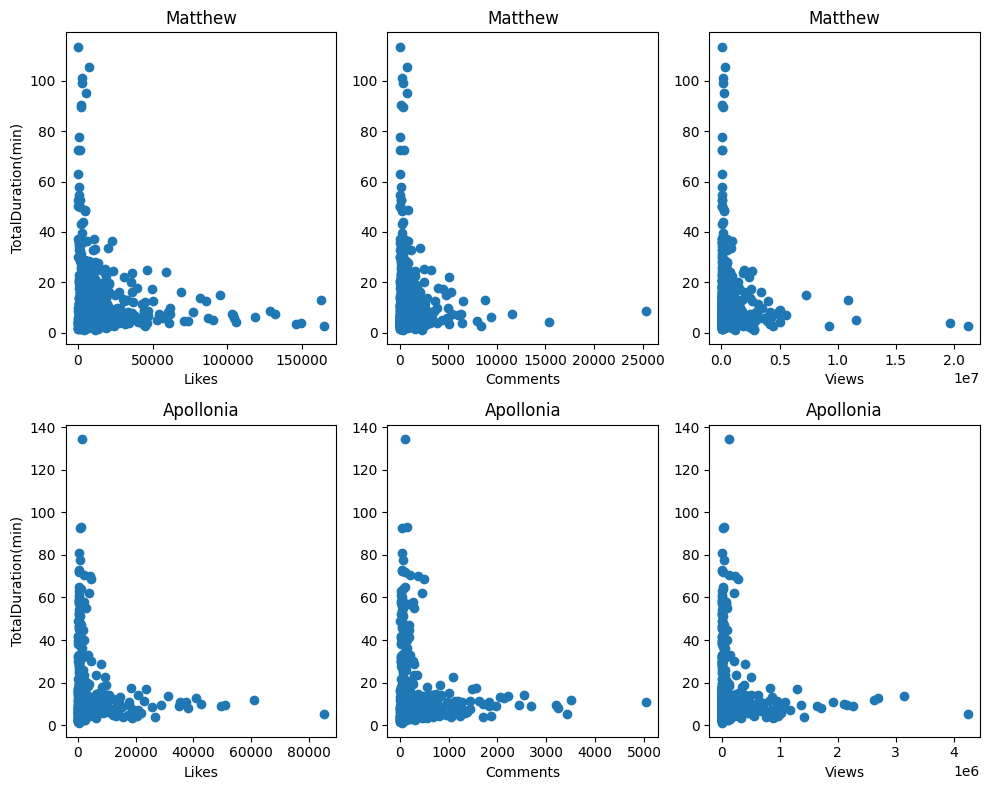

In [33]:
# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot scatter
axes[0, 0].scatter(mat_df['Likes'], mat_df['TotalDuration(sec)']/60)
axes[0, 1].scatter(mat_df['Comments'], mat_df['TotalDuration(sec)']/60)
axes[0, 2].scatter(mat_df['Views'], mat_df['TotalDuration(sec)']/60)

axes[1, 0].scatter(apo_df['Likes'], apo_df['TotalDuration(sec)']/60)
axes[1, 1].scatter(apo_df['Comments'], apo_df['TotalDuration(sec)']/60)
axes[1, 2].scatter(apo_df['Views'], apo_df['TotalDuration(sec)']/60)


# Add axis labels
axes[0, 0].set_ylabel('TotalDuration(min)')
axes[0, 0].set_xlabel('Likes')
axes[0, 1].set_xlabel('Comments')
axes[0, 2].set_xlabel('Views')

axes[1, 0].set_ylabel('TotalDuration(min)')
axes[1, 0].set_xlabel('Likes')
axes[1, 1].set_xlabel('Comments')
axes[1, 2].set_xlabel('Views')


axes[0, 0].set_title('Matthew')
axes[0, 1].set_title('Matthew')
axes[0, 2].set_title('Matthew')
axes[1, 0].set_title('Apollonia')
axes[1, 1].set_title('Apollonia')
axes[1, 2].set_title('Apollonia')


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Top Performing Videos: 

#### Top Videos based on Engagement Rate

In [139]:
mat_df_sortedEngag = mat_df.sort_values(by='Engagement Rate', ascending=False)
apo_df_sortedEngag = apo_df.sort_values(by='Engagement Rate', ascending=False)

In [243]:
mat_top50Engag = list(mat_df_sortedEngag['Title'].head(50))
mat_top50Engag[0:20]

["Women's Safety – It Belongs to All of Us (Matthew Hussey)",
 'Are You Having a Complicated Christmas?',
 "If He's Sending Mixed Signals, Text Him THIS",
 'Can You Truly ‘Grow Up’ Without Having Kids?',
 '5 Things to Know Before You “Netflix and Chill” With Someone',
 'Preparing for a Date',
 'Is Your To-Do List Making You Miserable? (Matthew Hussey)',
 'I Have a Huge Announcement',
 'Feel Like Sh*t? Go for a Tiny Victory (Matthew Hussey, Get The Guy)',
 'Why You Can Overcome Anything (Matthew Hussey, Get The Guy)',
 'Men’s Frustration at Women’s Dating Choices',
 'For Anyone Who Feels Rejected or Invisible in Dating',
 'To My Community (Matthew Hussey)',
 'How to Deal With the Fear of Never Finding Your Person',
 '7 Powerful People Skills to Make Your Voice Heard (Matthew Hussey)',
 '"Am I the Only One Not Living My ‘Best Life’ During Coronavirus?" (Matthew Hussey)',
 '"You Need To Be Happy Alone Before You Date”… TRUTH OR MYTH?  | Matthew Hussey',
 'Why We Always Chase the Wrong Per

In [242]:
apo_top50Engag = list(apo_df_sortedEngag['Title'].head(50))
apo_top50Engag[0:20]

['Merry Christmas and Happy Holidays Everyone!',
 "Happy New Year! 🎉  (Let's Bring In 2023 With This)",
 '200,000 Subscribers | My Thank You, xoxo ♥️',
 'Men With Broken Relationship With Their Mother! (This BROKE Me)',
 '50,000 Subscribers, Thank You! Q&A w/Apollonia',
 'Johnny Depp Vs  Amber Heard | What This Means For Men Dating & Relationship Coach Shares Thoughts',
 'Why Successful Men Struggle to Attract The Woman They REALLY Want! (NO One Talks About This)',
 'How To Deal With NEGATIVE and TOXIC People!',
 "How To Get A Woman's Phone Number! LIVE",
 '6 Things A Woman Should Bring To The Table In 2024!',
 "Where To Meet High Quality Women (Places You Haven't Heard Before)",
 '5 Traits EVERY Man Should Look For In A High-Quality Woman To Date! ( Is She Worth It?)',
 '5 Life Changing Tips To Conquer Your Love Life in 2020!',
 'HEALING CHILDHOOD TRAUMA: 9 Steps To Begin Healing! (Apollonia Ponti)',
 '3 Powerful Ways To Reprogramming Your Subconscious Mind & Feel Free!',
 "Why He Doe

#### Top Videos based on Views

In [119]:
mat_df_sortedViews = mat_df.sort_values(by='Views', ascending= False)
apo_df_sortedViews = apo_df.sort_values(by='Views', ascending= False)

In [143]:
mat_top50Views = list(mat_df_sortedEngag['Title'].head(50))
mat_top50Views[0:10]

["Women's Safety – It Belongs to All of Us (Matthew Hussey)",
 'Are You Having a Complicated Christmas?',
 "If He's Sending Mixed Signals, Text Him THIS",
 'Can You Truly ‘Grow Up’ Without Having Kids?',
 '5 Things to Know Before You “Netflix and Chill” With Someone',
 'Preparing for a Date',
 'Is Your To-Do List Making You Miserable? (Matthew Hussey)',
 'I Have a Huge Announcement',
 'Feel Like Sh*t? Go for a Tiny Victory (Matthew Hussey, Get The Guy)',
 'Why You Can Overcome Anything (Matthew Hussey, Get The Guy)']

In [142]:
apo_top50Views = list(apo_df_sortedEngag['Title'].head(50))
apo_top50Views[0:10]

['Merry Christmas and Happy Holidays Everyone!',
 "Happy New Year! 🎉  (Let's Bring In 2023 With This)",
 '200,000 Subscribers | My Thank You, xoxo ♥️',
 'Men With Broken Relationship With Their Mother! (This BROKE Me)',
 '50,000 Subscribers, Thank You! Q&A w/Apollonia',
 'Johnny Depp Vs  Amber Heard | What This Means For Men Dating & Relationship Coach Shares Thoughts',
 'Why Successful Men Struggle to Attract The Woman They REALLY Want! (NO One Talks About This)',
 'How To Deal With NEGATIVE and TOXIC People!',
 "How To Get A Woman's Phone Number! LIVE",
 '6 Things A Woman Should Bring To The Table In 2024!']

## Content Analysis

### Title

In [234]:
def create_all_words_str(df_column, remove_list=None):
    """
    Process a DataFrame column of strings to remove stop words and concatenate all words into a single string.

    Args:
    df_column (pd.Series): A pandas Series object containing strings for each element.
    remove_list (list): A list of substrings to be removed from each string in the column.
    
    Returns:
    str: A single string containing all the words from the input Series, with stop words removed.
    """
    
    stop_words = set(stopwords.words('english'))
    
    # Remove specified substrings and stop words from each title in the column
    def clean_text(text):
        if remove_list:
            for substr in remove_list:
                text = text.replace(substr, '')
        return [item for item in str(text).split() if item.lower() not in stop_words]
    
    clean_titles = df_column.apply(clean_text)
    
    # Flatten the list of lists into a single list of words
    all_words = [word for title in clean_titles for word in title]
    
    # Join all words into a single string
    all_words_str = ' '.join(all_words)
    
    return all_words_str
    

def plot_cloud(wordcloud, title="Word Cloud"):
    '''
    Description:

    The plot_cloud function is designed to create a visualization of a word cloud using Matplotlib. 
    It takes in a word cloud object (wordcloud) as input and optionally allows for a title to be added to the plot.
    
    Parameters:
    
    wordcloud (required): A word cloud object generated using a library like wordcloud.
    
    title (optional): A string specifying the title to be displayed above the word cloud plot. If not provided, the default title is "Word Cloud".
    
    Output:
    
    Displays a word cloud visualization with optional title using Matplotlib.
    '''
    
    plt.figure(figsize=(12, 5))
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

In [209]:
matTitle = create_all_words_str(mat_df['Title'], remove_list=['Matthew', 'Hussey'])
apoTitle = create_all_words_str(apo_df['Title'], remove_list=['Apollonia', 'Ponti'])

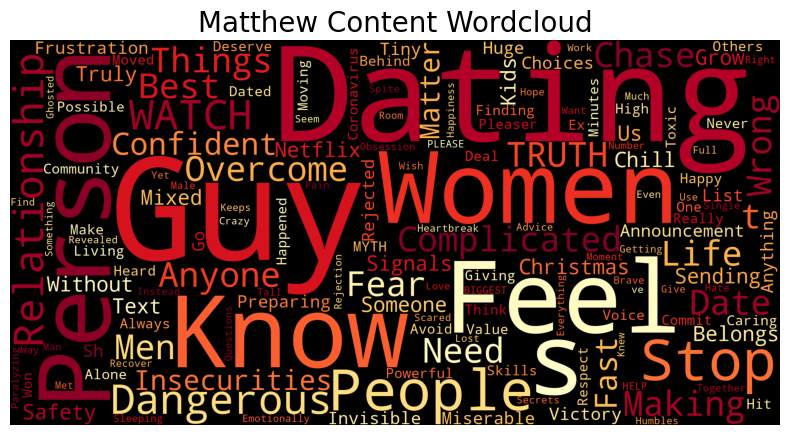

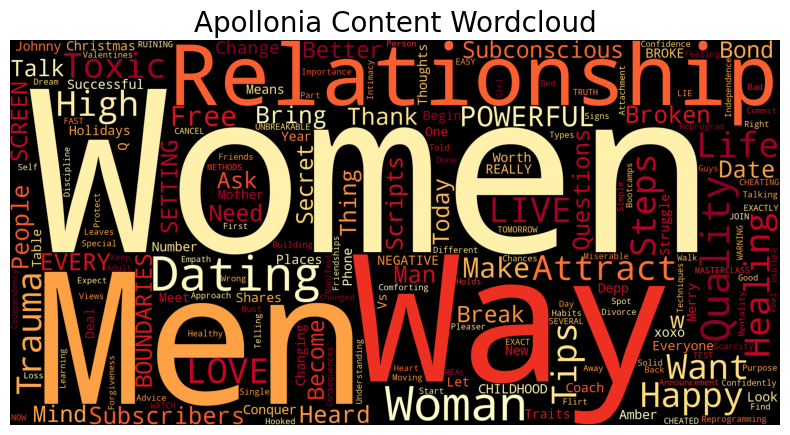

In [236]:

wordcloud_mat = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='YlOrRd', collocations=False).generate(matTitle)
plot_cloud(wordcloud_mat, title='Matthew Content Wordcloud')


wordcloud_apo = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='YlOrRd', collocations=False).generate(apoTitle)
plot_cloud(wordcloud_apo, title='Apollonia Content Wordcloud')

# to retrieve the normalized frequency of the words
#wordcloud_mat.words_

### Top 20 Engaged videos - Title

In [240]:
matTitle = create_all_words_str(mat_df_sortedEngag['Title'].head(20), remove_list=['Matthew', 'Hussey'])
apoTitle = create_all_words_str(apo_df_sortedEngag['Title'].head(20), remove_list=['Apollonia', 'Ponti'])

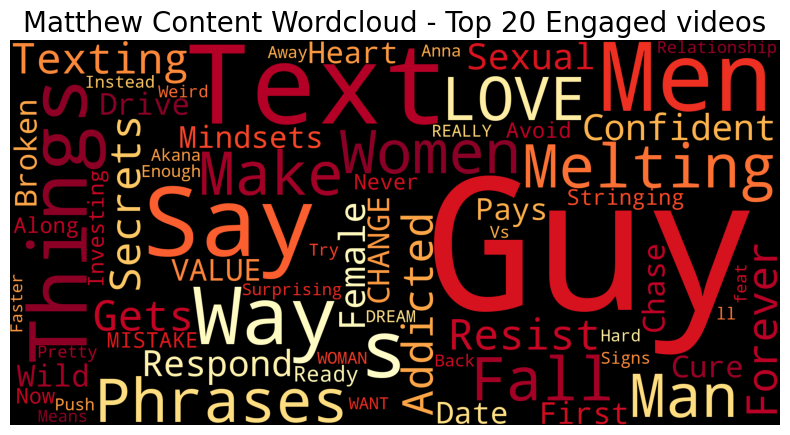

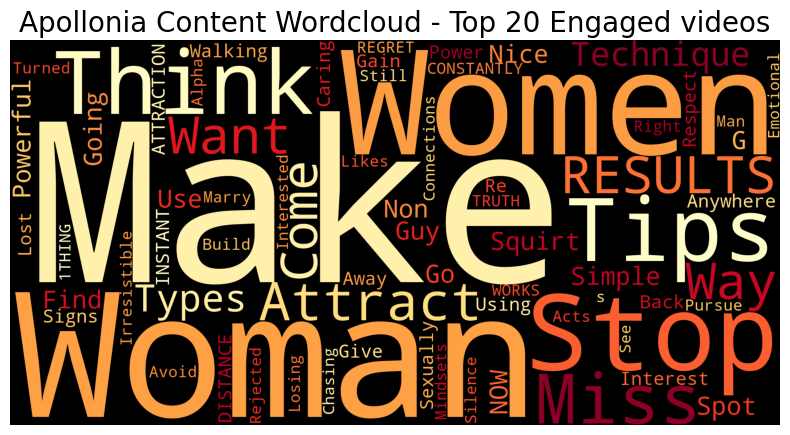

In [246]:
wordcloud_mat = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='YlOrRd', collocations=False).generate(matTitle)
plot_cloud(wordcloud_mat, title='Matthew Content Wordcloud - Top 20 Engaged videos')


wordcloud_apo = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='YlOrRd', collocations=False).generate(apoTitle)
plot_cloud(wordcloud_apo, title='Apollonia Content Wordcloud - Top 20 Engaged videos')

### Top 20 Viewed videos - Title

In [244]:
matTitle = create_all_words_str(mat_df_sortedViews['Title'].head(20), remove_list=['Matthew', 'Hussey'])
apoTitle = create_all_words_str(apo_df_sortedViews['Title'].head(20), remove_list=['Apollonia', 'Ponti'])

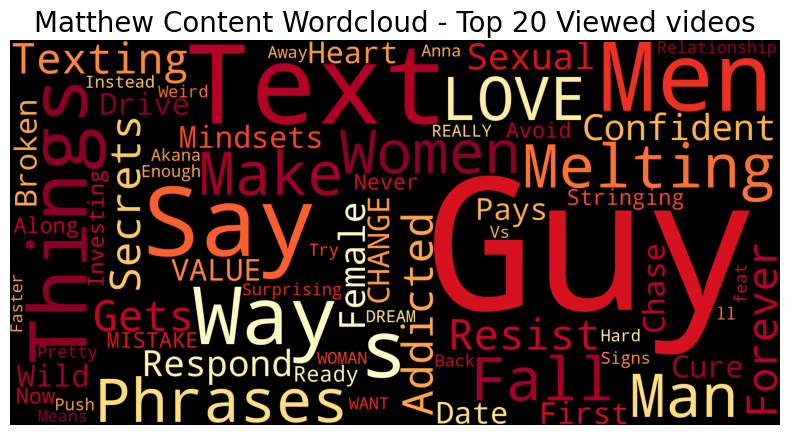

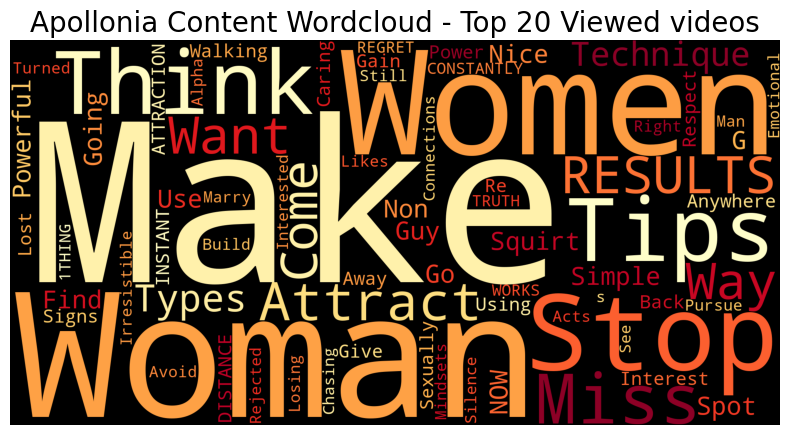

In [247]:
wordcloud_mat = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='YlOrRd', collocations=False).generate(matTitle)
plot_cloud(wordcloud_mat, title='Matthew Content Wordcloud - Top 20 Viewed videos')


wordcloud_apo = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='YlOrRd', collocations=False).generate(apoTitle)
plot_cloud(wordcloud_apo, title='Apollonia Content Wordcloud - Top 20 Viewed videos')

# Save data

In [34]:
import os

if not os.path.exists("../data/clean/"):
    os.makedirs("../data/clean/")

if not os.path.exists("../data/raw/"):
    os.makedirs("../data/raw/")

filename = "data_matthew.csv"
relative_path = "../data/raw/"

video_mat.to_csv(relative_path+filename, index='False', sep='\t', encoding='utf-8', header=True)
